In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
from scipy.optimize import minimize
import pandas as pd

In [2]:
# functions to generate data
# hyperplane    
    
def generate_linear_data(total, ratio=0.9, dim=5, shuffle=True,
                         linear_weights=None, interval=[-10, 10],
                         noise=False, seed=0):
    
    assert abs(ratio) <= 1
    
    if linear_weights is None:
        linear_weights = (np.arange(dim+1) + 1) / 10
        
    assert len(linear_weights) == dim + 1
    
    true_x = generate_linear_x(int(total * ratio), dim, linear_weights, interval, seed=seed)
    
    np.random.seed(seed)
    fake_x = np.random.uniform(-10, 10, size=(total - int(total * ratio), dim))
    
    if noise:
        if noise is list or noise is tuple:
            true_x = inject_noise(true_x, noise[0], noise[1], seed=seed)
            fake_x = inject_noise(fake_x, noise[0], noise[1], seed=seed)
        else:            
            true_x = inject_noise(true_x)
            fake_x = inject_noise(fake_x)
    
    true_data = np.hstack((true_x, np.ones(int(total * ratio)).reshape(-1, 1)))    
    fake_data = np.hstack((fake_x, np.zeros(total - int(total * ratio)).reshape(-1, 1)))
    
    x_all = np.vstack((true_data, fake_data))
    
    if shuffle:
        np.random.seed(seed)
        np.random.shuffle(x_all)
    
    return x_all


# generate x that lies on the hyperplane defined by beta
def generate_linear_x(n, dim, beta, interval=[-10, 10], seed=0):
    '''
    n: num of samples to generate
    dim: dimension of X
    beta: true weights
    interval: interval to generate data
    '''
    
    np.random.seed(seed+2023)
    x_ = np.random.uniform(interval[0], interval[1], size=(n, dim-1))

    x_dim = (-beta[0] - x_ @ beta[1:-1]) / beta[-1]
    
    return np.hstack((x_, x_dim.reshape(-1,1)))


def inject_noise(X, mean=0, stddev=0.1, seed=0):
    
    np.random.seed(seed)
    return X + np.random.normal(mean, stddev, size=(X.shape))

In [3]:
def evaluate_linear(dim, num_data, file_path=None, ratio=0.5, noise=(0, 0.1),
                    sigma=10., linear_weights=None, plot=True, loss='mse', seed=0):
    '''
    file_path: None to generate fresh data, list of 2 strings to denote train and test data
    ratio: imbalance of data
    noise: False to avoid injecting noise. Else, tuple of mean and std dev of noise to be injected
    '''       
    if linear_weights is None:
        linear_weights = (np.arange(dim+1) + 1) / 10
    
    if file_path is None:
        data = generate_linear_data(num_data, ratio=ratio, dim=dim, shuffle=True,
                         linear_weights=linear_weights, interval=[-10, 10],
                         noise=False, seed=seed)
        data_test = generate_linear_data(num_data, ratio=ratio, dim=dim, shuffle=True,
                         linear_weights=linear_weights, interval=[-10, 10],
                         noise=False, seed=seed)
    else:
        with open(file_path[0], "rb") as f:
            data = np.load(f)
        with open(file_path[1], "rb") as f:
            data_test = np.load(f)

    X, y = data[:, :-1], data[:, -1]

    if noise != False:
        X = inject_noise(X, noise[0], noise[1], seed=seed)

    # Optimisation
    
    # x = [1, x_1, x_2]

    X_ = np.vstack((X.shape[0] * [1], X.T)).T
    
    np.random.seed(seed+42)
    beta = np.random.randn(X_.shape[1])
    
    def loss_fn(beta):

        y_pred = np.exp(-0.5 * np.square(X_.dot(beta) / sigma)) 

        # without smoothing
        # tildy = X_.dot(beta) != 0

        if loss == "mse":
            return np.linalg.norm(y - y_pred) ** 2
        elif loss == "bce":
            return metrics.log_loss(y, y_pred)
        else:
            return loss(y, y_pred)

    res = minimize(loss_fn, beta, method='BFGS')
    beta_pred = res.x
    
    
    # Testing
    x_test, y_test = data_test[:, :-1], data_test[:, -1]
    output_pred = beta_pred[0] + x_test @ beta_pred[1:]
    class_pred = -np.abs(output_pred)
    
    fpr, tpr, thresholds_roc = metrics.roc_curve(y_test, class_pred, pos_label=1)
    precision, recall, thresholds_pr = metrics.precision_recall_curve(y_test, class_pred, pos_label=1)
    
    auroc = metrics.auc(fpr, tpr)
    aupr = metrics.auc(recall, precision)
    
    if plot:

        fig, axs = plt.subplots(nrows=1, ncols=2)

        axs[0].set_title('ROC Curve of Test Data')
        axs[0].plot(fpr, tpr, 'blue', alpha=0.8,
                 label='AUC = %0.2f' % auroc)
        axs[0].legend(loc = 'lower right')
        axs[0].plot([0, 1], [0, 1],'r--')
        axs[0].set_xlim([0, 1])
        axs[0].set_ylim([0, 1])
        axs[0].set_ylabel('True Positive Rate')
        axs[0].set_xlabel('False Positive Rate')

        axs[1].set_title('Precision-Recall Curve of Test Data')
        axs[1].plot(recall, precision, 'blue', alpha=0.8,
                 label='AUC = %0.2f' % aupr)
        axs[1].legend(loc = 'lower right')
        axs[1].axhline(y_test.sum()/num_data, linestyle='--', color='r')
        axs[1].set_xlim([0, 1])
        axs[1].set_ylim([0, 1])
        axs[1].set_ylabel('Precision')
        axs[1].set_xlabel('Recall')
        plt.show()
    
    return beta_pred, auroc, aupr

# Linear Classification with $\sigma=10$
Varying noise standard deviations: multiples of 0.5, 1, 1.5 and 2 of the standard deviation of the distribution that generates the weights.

In [4]:
def get_results(dims, noises, data="constant", loss='mse', sigma=10.,
                repeats=20, plot=True, latex=True, transpose=True):
    
    if data == "constant":
        num_data = [100 for dim in dims]
    else:
        num_data = [20 * dim for dim in dims]

    auprs_mean = []
    auprs_std = []
    auprs = {"Dim": dims, "AUPR Mean": [], "AUPR StDev": []}

    for j, dim in enumerate(dims):
        auprs_dim = {"Noise": noises, "AUPR Mean": [], "AUPR StDev": []}
        for stdev in noises:
            print(f"{dim}D noisy data, {stdev} stdev")
            auroc_list = []
            aupr_list = []

            for i in range(repeats):

                np.random.seed(i+2023)
                beta_true = np.random.normal(scale=1, size=(dim+1))

                pred, auroc, aupr = evaluate_linear(dim=dim, num_data=int(num_data[j]),
                                                    file_path=None, ratio=0.9,
                                                    noise=(0, stdev), sigma=sigma,
                                                    linear_weights=beta_true,
                                                    plot=False, seed=i,
                                                   loss=loss)

                auroc_list.append(auroc)
                aupr_list.append(aupr)

            auprs_dim["AUPR Mean"].append(np.mean(aupr_list))
            auprs_dim["AUPR StDev"].append(np.std(aupr_list))

        print("Dimension:", dim)
        display(pd.DataFrame(auprs_dim))

        auprs_mean.append(auprs_dim["AUPR Mean"])
        auprs_std.append(auprs_dim["AUPR StDev"])

    auprs_mean = np.array(auprs_mean)
    auprs_std = np.array(auprs_std)
    
    if plot:

        for noise, mean, std in zip(noises, auprs_mean.T, auprs_std.T):
            plt.title(f"AUPR with Noise: {noise}")
            plt.plot(dims, mean)
            plt.fill_between(dims, mean - std, mean + std, alpha=0.5)
            plt.xlabel("Dim")
            plt.ylabel("AUPR")
            plt.show()

        for dim, mean, std in zip(dims, auprs_mean, auprs_std):
            plt.title(f"AUPR on Dim: {dim}")
            plt.plot(noises, mean)
            plt.fill_between(noises, mean + std, mean - std, alpha=0.5)
            plt.xlabel("Noise")
            plt.ylabel("AUPR")
            plt.show()
        
    if latex:
        
        if transpose:
        
            print("\\hline")
            print("Dim$\\backslash$Noise Std", end="")
            for n in noises:
                print(f" & {n}", end="")

            print("\\\\")
            print("\\hline")

            for dim, means, stds in zip(dims, auprs_mean, auprs_std):

                print(dim, end="")
                for mean, std in zip(means, stds):
                    print(f" & {np.round(mean, 2)}$\\pm${np.round(std, 2)}", end="")
                print("\\\\")

            print("\\hline")
        
        else:
        
            print("\\hline")
            print("Noise Std$\\backslash$Dim", end="")
            for dim in dims:
                print(f" & {dim}", end="")

            print("\\\\")
            print("\\hline")

            for noise, means, stds in zip(noises, auprs_mean, auprs_std):

                print(noise, end="")
                for mean, std in zip(means, stds):
                    print(f" & {np.round(mean, 2)}$\\pm${np.round(std, 2)}", end="")
                print("\\\\")

            print("\\hline")
        
    return auprs_mean, auprs_std

## MSE

### 100 Data Samples

5D noisy data, 0.0 stdev
5D noisy data, 0.5 stdev
5D noisy data, 1.0 stdev
5D noisy data, 1.5 stdev
5D noisy data, 2.0 stdev
Dimension: 5


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.987203,0.055780
1,0.5,0.984782,0.055428
2,1.0,0.979832,0.054731
3,1.5,0.973860,0.054453
4,2.0,0.968697,0.054113


10D noisy data, 0.0 stdev
10D noisy data, 0.5 stdev
10D noisy data, 1.0 stdev
10D noisy data, 1.5 stdev
10D noisy data, 2.0 stdev
Dimension: 10


,Noise,AUPR Mean,AUPR StDev
0,0.0,1.000000,1.110223e-16
1,0.5,0.999683,7.680697e-04
2,1.0,0.995779,1.108554e-02
3,1.5,0.995102,6.546459e-03
4,2.0,0.984689,1.903631e-02


15D noisy data, 0.0 stdev
15D noisy data, 0.5 stdev
15D noisy data, 1.0 stdev
15D noisy data, 1.5 stdev
15D noisy data, 2.0 stdev
Dimension: 15


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.986076,0.055407
1,0.5,0.985475,0.055440
2,1.0,0.981972,0.054248
3,1.5,0.977487,0.054576
4,2.0,0.986385,0.013804


20D noisy data, 0.0 stdev
20D noisy data, 0.5 stdev
20D noisy data, 1.0 stdev
20D noisy data, 1.5 stdev
20D noisy data, 2.0 stdev
Dimension: 20


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.998907,0.003384
1,0.5,0.997652,0.003889
2,1.0,0.996826,0.002966
3,1.5,0.993974,0.007279
4,2.0,0.990867,0.007292


25D noisy data, 0.0 stdev
25D noisy data, 0.5 stdev
25D noisy data, 1.0 stdev
25D noisy data, 1.5 stdev
25D noisy data, 2.0 stdev
Dimension: 25


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.999432,0.000925
1,0.5,0.999047,0.001780
2,1.0,0.988703,0.042040
3,1.5,0.994563,0.006048
4,2.0,0.995760,0.004483


30D noisy data, 0.0 stdev
30D noisy data, 0.5 stdev
30D noisy data, 1.0 stdev
30D noisy data, 1.5 stdev
30D noisy data, 2.0 stdev
Dimension: 30


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.987008,0.055739
1,0.5,0.986442,0.055619
2,1.0,0.985807,0.055493
3,1.5,0.985180,0.055357
4,2.0,0.982771,0.054942


35D noisy data, 0.0 stdev
35D noisy data, 0.5 stdev
35D noisy data, 1.0 stdev
35D noisy data, 1.5 stdev
35D noisy data, 2.0 stdev
Dimension: 35


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.999909,0.000249
1,0.5,0.999883,0.000238
2,1.0,0.999120,0.001095
3,1.5,0.995781,0.006977
4,2.0,0.996749,0.002943


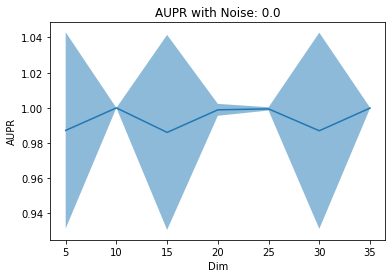

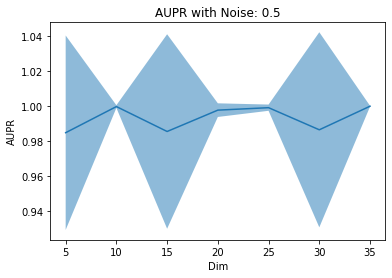

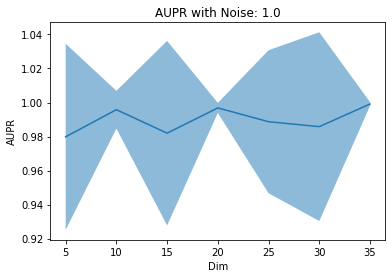

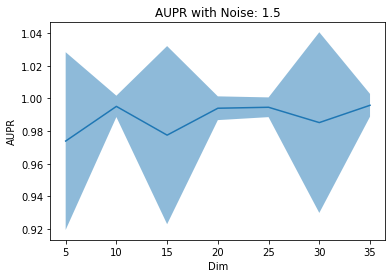

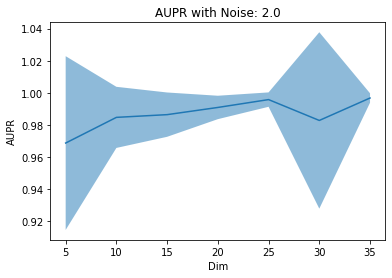

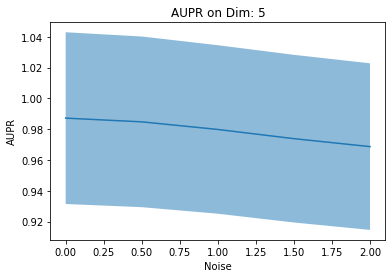

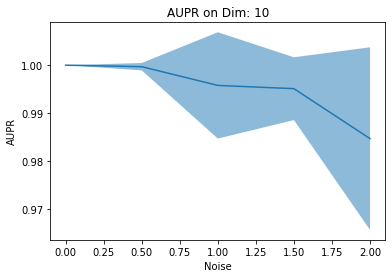

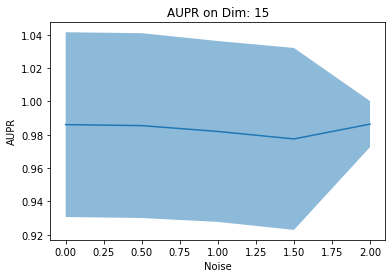

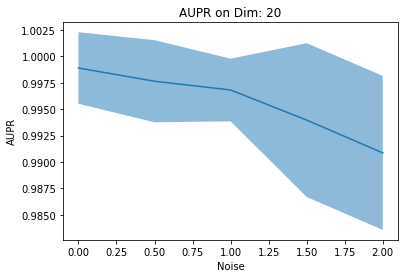

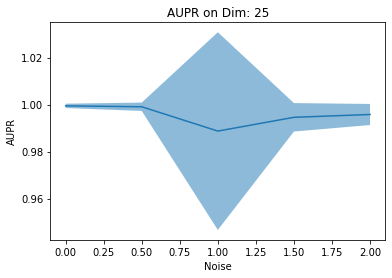

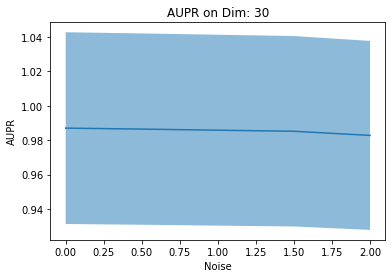

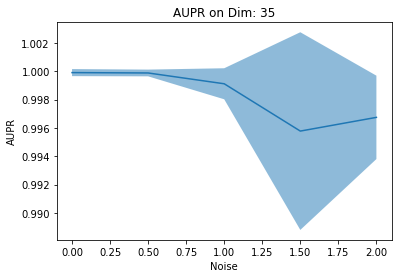

\hline
Dim$\backslash$Noise Std & 0.0 & 0.5 & 1.0 & 1.5 & 2.0\\
\hline
5 & 0.99$\pm$0.06 & 0.98$\pm$0.06 & 0.98$\pm$0.05 & 0.97$\pm$0.05 & 0.97$\pm$0.05\\
10 & 1.0$\pm$0.0 & 1.0$\pm$0.0 & 1.0$\pm$0.01 & 1.0$\pm$0.01 & 0.98$\pm$0.02\\
15 & 0.99$\pm$0.06 & 0.99$\pm$0.06 & 0.98$\pm$0.05 & 0.98$\pm$0.05 & 0.99$\pm$0.01\\
20 & 1.0$\pm$0.0 & 1.0$\pm$0.0 & 1.0$\pm$0.0 & 0.99$\pm$0.01 & 0.99$\pm$0.01\\
25 & 1.0$\pm$0.0 & 1.0$\pm$0.0 & 0.99$\pm$0.04 & 0.99$\pm$0.01 & 1.0$\pm$0.0\\
30 & 0.99$\pm$0.06 & 0.99$\pm$0.06 & 0.99$\pm$0.06 & 0.99$\pm$0.06 & 0.98$\pm$0.05\\
35 & 1.0$\pm$0.0 & 1.0$\pm$0.0 & 1.0$\pm$0.0 & 1.0$\pm$0.01 & 1.0$\pm$0.0\\
\hline


In [5]:
dims = [5, 10, 15, 20, 25, 30, 35]
noises = [0., 0.5, 1., 1.5, 2.0]

auprs_mean, auprs_std = get_results(dims, noises, data="constant", loss='mse',
                repeats=20, plot=True, latex=True)

### Amount of Data = $20 \times$ Dimension

5D noisy data, 0.0 stdev
5D noisy data, 0.5 stdev
5D noisy data, 1.0 stdev
5D noisy data, 1.5 stdev
5D noisy data, 2.0 stdev
Dimension: 5


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.987203,0.055780
1,0.5,0.984782,0.055428
2,1.0,0.979832,0.054731
3,1.5,0.973860,0.054453
4,2.0,0.968697,0.054113


10D noisy data, 0.0 stdev
10D noisy data, 0.5 stdev
10D noisy data, 1.0 stdev
10D noisy data, 1.5 stdev
10D noisy data, 2.0 stdev
Dimension: 10


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.999998,0.000007
1,0.5,0.997388,0.004219
2,1.0,0.994256,0.006114
3,1.5,0.991867,0.004884
4,2.0,0.986774,0.007190


15D noisy data, 0.0 stdev
15D noisy data, 0.5 stdev
15D noisy data, 1.0 stdev
15D noisy data, 1.5 stdev
15D noisy data, 2.0 stdev
Dimension: 15


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.999976,0.000094
1,0.5,0.983159,0.052440
2,1.0,0.994771,0.004690
3,1.5,0.978995,0.051014
4,2.0,0.984331,0.008515


20D noisy data, 0.0 stdev
20D noisy data, 0.5 stdev
20D noisy data, 1.0 stdev
20D noisy data, 1.5 stdev
20D noisy data, 2.0 stdev
Dimension: 20


,Noise,AUPR Mean,AUPR StDev
0,0.0,1.000000,0.000000
1,0.5,0.996002,0.004256
2,1.0,0.991390,0.006714
3,1.5,0.986743,0.009222
4,2.0,0.982242,0.010064


25D noisy data, 0.0 stdev
25D noisy data, 0.5 stdev
25D noisy data, 1.0 stdev
25D noisy data, 1.5 stdev
25D noisy data, 2.0 stdev
Dimension: 25


,Noise,AUPR Mean,AUPR StDev
0,0.0,1.000000,0.000000
1,0.5,0.996153,0.003538
2,1.0,0.991739,0.004193
3,1.5,0.985639,0.008142
4,2.0,0.982709,0.007097


30D noisy data, 0.0 stdev
30D noisy data, 0.5 stdev
30D noisy data, 1.0 stdev
30D noisy data, 1.5 stdev
30D noisy data, 2.0 stdev
Dimension: 30


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.987397,0.054937
1,0.5,0.984531,0.054510
2,1.0,0.979547,0.053746
3,1.5,0.974166,0.053139
4,2.0,0.971501,0.052437


35D noisy data, 0.0 stdev
35D noisy data, 0.5 stdev
35D noisy data, 1.0 stdev
35D noisy data, 1.5 stdev
35D noisy data, 2.0 stdev
Dimension: 35


,Noise,AUPR Mean,AUPR StDev
0,0.0,1.000000,0.000000
1,0.5,0.996024,0.003909
2,1.0,0.990202,0.007131
3,1.5,0.986153,0.006277
4,2.0,0.979943,0.007913


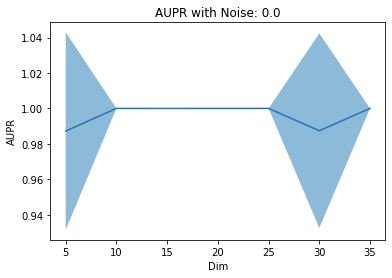

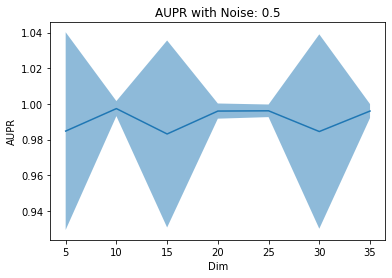

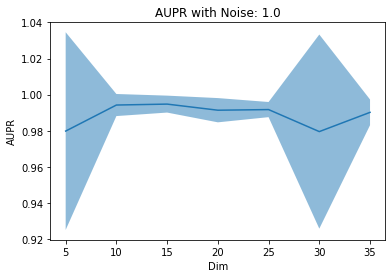

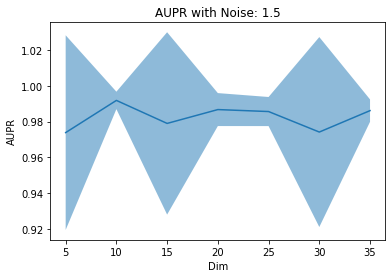

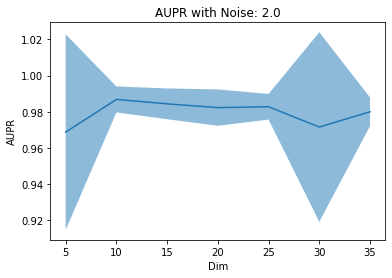

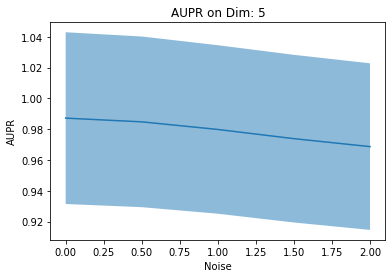

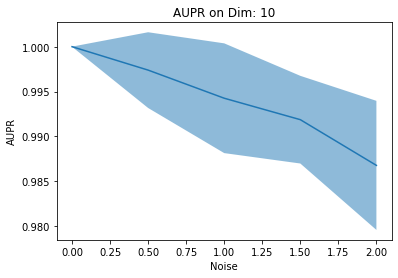

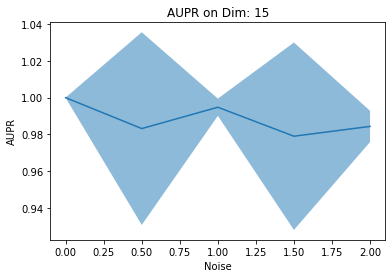

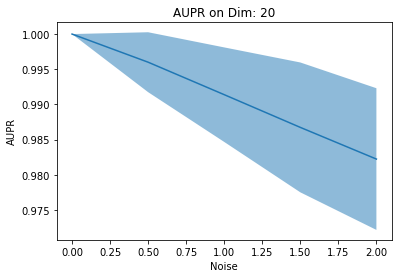

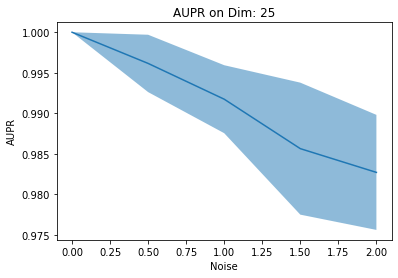

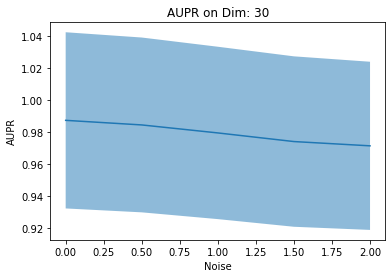

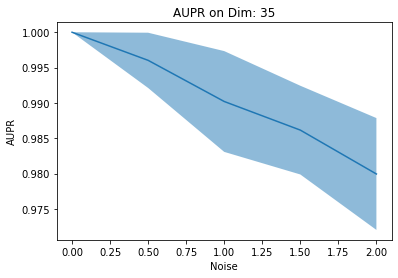

\hline
Dim$\backslash$Noise Std & 0.0 & 0.5 & 1.0 & 1.5 & 2.0\\
\hline
5 & 0.99$\pm$0.06 & 0.98$\pm$0.06 & 0.98$\pm$0.05 & 0.97$\pm$0.05 & 0.97$\pm$0.05\\
10 & 1.0$\pm$0.0 & 1.0$\pm$0.0 & 0.99$\pm$0.01 & 0.99$\pm$0.0 & 0.99$\pm$0.01\\
15 & 1.0$\pm$0.0 & 0.98$\pm$0.05 & 0.99$\pm$0.0 & 0.98$\pm$0.05 & 0.98$\pm$0.01\\
20 & 1.0$\pm$0.0 & 1.0$\pm$0.0 & 0.99$\pm$0.01 & 0.99$\pm$0.01 & 0.98$\pm$0.01\\
25 & 1.0$\pm$0.0 & 1.0$\pm$0.0 & 0.99$\pm$0.0 & 0.99$\pm$0.01 & 0.98$\pm$0.01\\
30 & 0.99$\pm$0.05 & 0.98$\pm$0.05 & 0.98$\pm$0.05 & 0.97$\pm$0.05 & 0.97$\pm$0.05\\
35 & 1.0$\pm$0.0 & 1.0$\pm$0.0 & 0.99$\pm$0.01 & 0.99$\pm$0.01 & 0.98$\pm$0.01\\
\hline


In [6]:
auprs_mean, auprs_std = get_results(dims, noises, data="linear", loss='mse',
                repeats=20, plot=True, latex=True)

## Log Loss

### 100 Data Samples

5D noisy data, 0.0 stdev
5D noisy data, 0.5 stdev
5D noisy data, 1.0 stdev
5D noisy data, 1.5 stdev
5D noisy data, 2.0 stdev
Dimension: 5


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.950030,0.056829
1,0.5,0.961808,0.052677
2,1.0,0.947984,0.052177
3,1.5,0.943971,0.050634
4,2.0,0.930356,0.048853


10D noisy data, 0.0 stdev
10D noisy data, 0.5 stdev
10D noisy data, 1.0 stdev
10D noisy data, 1.5 stdev
10D noisy data, 2.0 stdev
Dimension: 10


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.975526,0.014587
1,0.5,0.976007,0.011543
2,1.0,0.975841,0.015731
3,1.5,0.965824,0.023255
4,2.0,0.958194,0.025488


15D noisy data, 0.0 stdev
15D noisy data, 0.5 stdev
15D noisy data, 1.0 stdev
15D noisy data, 1.5 stdev
15D noisy data, 2.0 stdev
Dimension: 15


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.980362,0.011296
1,0.5,0.982649,0.008627
2,1.0,0.980713,0.008742
3,1.5,0.973944,0.013905
4,2.0,0.968735,0.010565


20D noisy data, 0.0 stdev
20D noisy data, 0.5 stdev
20D noisy data, 1.0 stdev
20D noisy data, 1.5 stdev
20D noisy data, 2.0 stdev
Dimension: 20


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.989632,0.003616
1,0.5,0.991738,0.004800
2,1.0,0.988195,0.004539
3,1.5,0.984357,0.007993
4,2.0,0.980166,0.009880


25D noisy data, 0.0 stdev
25D noisy data, 0.5 stdev
25D noisy data, 1.0 stdev
25D noisy data, 1.5 stdev
25D noisy data, 2.0 stdev
Dimension: 25


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.990702,0.006444
1,0.5,0.990306,0.005185
2,1.0,0.990573,0.008633
3,1.5,0.988870,0.005510
4,2.0,0.984662,0.010978


30D noisy data, 0.0 stdev
30D noisy data, 0.5 stdev
30D noisy data, 1.0 stdev
30D noisy data, 1.5 stdev
30D noisy data, 2.0 stdev
Dimension: 30


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.983223,0.054908
1,0.5,0.983060,0.054872
2,1.0,0.980080,0.054376
3,1.5,0.978918,0.054230
4,2.0,0.973571,0.053779


35D noisy data, 0.0 stdev
35D noisy data, 0.5 stdev
35D noisy data, 1.0 stdev
35D noisy data, 1.5 stdev
35D noisy data, 2.0 stdev
Dimension: 35


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.998203,0.001514
1,0.5,0.997490,0.002284
2,1.0,0.996778,0.002473
3,1.5,0.996080,0.001796
4,2.0,0.991812,0.007629


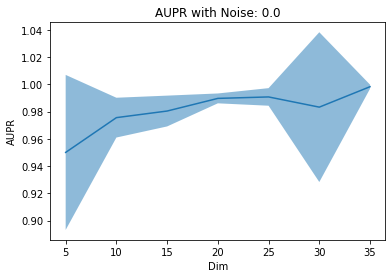

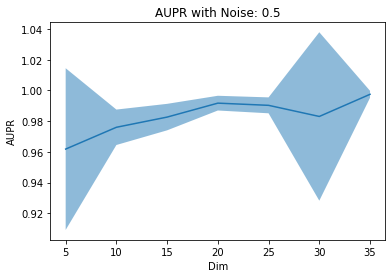

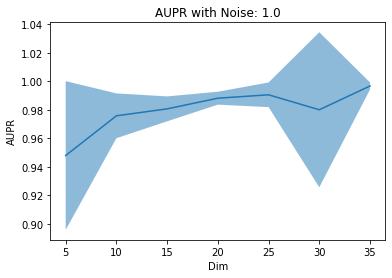

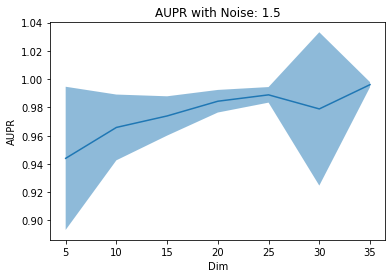

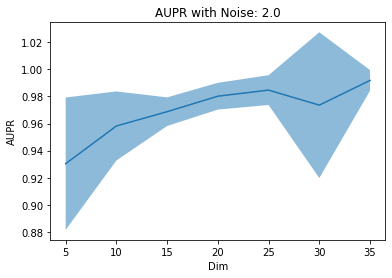

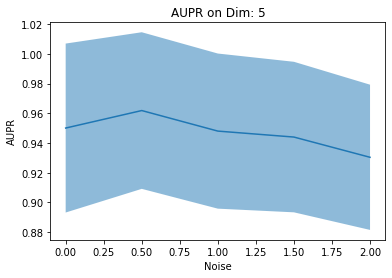

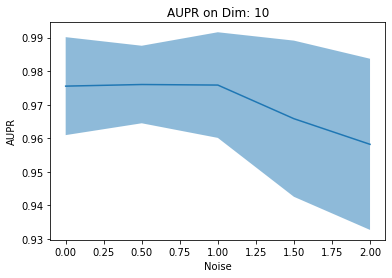

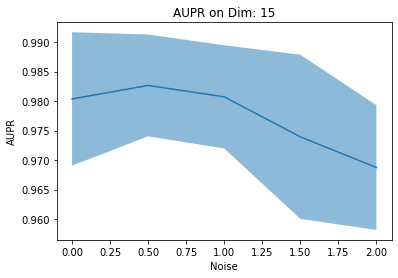

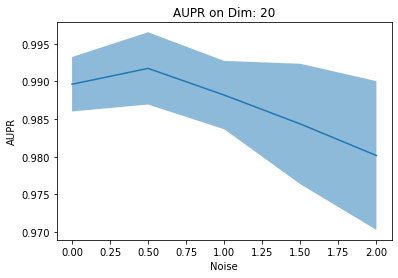

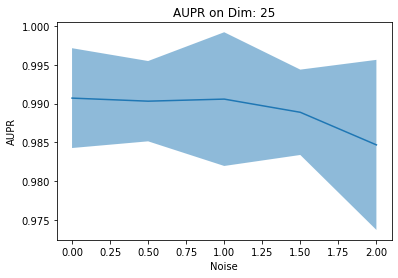

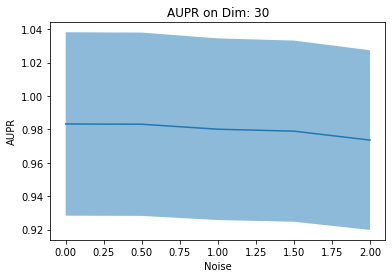

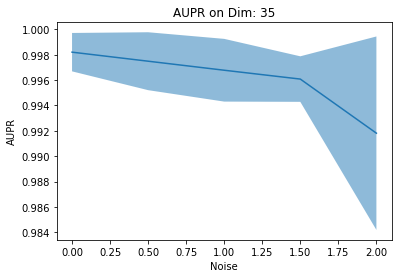

\hline
Dim$\backslash$Noise Std & 0.0 & 0.5 & 1.0 & 1.5 & 2.0\\
\hline
5 & 0.95$\pm$0.06 & 0.96$\pm$0.05 & 0.95$\pm$0.05 & 0.94$\pm$0.05 & 0.93$\pm$0.05\\
10 & 0.98$\pm$0.01 & 0.98$\pm$0.01 & 0.98$\pm$0.02 & 0.97$\pm$0.02 & 0.96$\pm$0.03\\
15 & 0.98$\pm$0.01 & 0.98$\pm$0.01 & 0.98$\pm$0.01 & 0.97$\pm$0.01 & 0.97$\pm$0.01\\
20 & 0.99$\pm$0.0 & 0.99$\pm$0.0 & 0.99$\pm$0.0 & 0.98$\pm$0.01 & 0.98$\pm$0.01\\
25 & 0.99$\pm$0.01 & 0.99$\pm$0.01 & 0.99$\pm$0.01 & 0.99$\pm$0.01 & 0.98$\pm$0.01\\
30 & 0.98$\pm$0.05 & 0.98$\pm$0.05 & 0.98$\pm$0.05 & 0.98$\pm$0.05 & 0.97$\pm$0.05\\
35 & 1.0$\pm$0.0 & 1.0$\pm$0.0 & 1.0$\pm$0.0 & 1.0$\pm$0.0 & 0.99$\pm$0.01\\
\hline


In [7]:
auprs_mean, auprs_std = get_results(dims, noises, data="constant", loss='bce',
                repeats=20, plot=True, latex=True)

### Amount of Data = $20 \times$ Dimension

5D noisy data, 0.0 stdev
5D noisy data, 0.5 stdev
5D noisy data, 1.0 stdev
5D noisy data, 1.5 stdev
5D noisy data, 2.0 stdev
Dimension: 5


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.950030,0.056829
1,0.5,0.961808,0.052677
2,1.0,0.947984,0.052177
3,1.5,0.943971,0.050634
4,2.0,0.930356,0.048853


10D noisy data, 0.0 stdev
10D noisy data, 0.5 stdev
10D noisy data, 1.0 stdev
10D noisy data, 1.5 stdev
10D noisy data, 2.0 stdev
Dimension: 10


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.964215,0.014493
1,0.5,0.960800,0.018696
2,1.0,0.962466,0.015142
3,1.5,0.953254,0.016594
4,2.0,0.950343,0.019247


15D noisy data, 0.0 stdev
15D noisy data, 0.5 stdev
15D noisy data, 1.0 stdev
15D noisy data, 1.5 stdev
15D noisy data, 2.0 stdev
Dimension: 15


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.961240,0.013761
1,0.5,0.953675,0.012847
2,1.0,0.946953,0.012438
3,1.5,0.946802,0.018013
4,2.0,0.944749,0.017729


20D noisy data, 0.0 stdev
20D noisy data, 0.5 stdev
20D noisy data, 1.0 stdev
20D noisy data, 1.5 stdev
20D noisy data, 2.0 stdev
Dimension: 20


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.958785,0.010985
1,0.5,0.956590,0.014167
2,1.0,0.957322,0.015154
3,1.5,0.952123,0.012411
4,2.0,0.950318,0.014868


25D noisy data, 0.0 stdev
25D noisy data, 0.5 stdev
25D noisy data, 1.0 stdev
25D noisy data, 1.5 stdev
25D noisy data, 2.0 stdev
Dimension: 25


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.959041,0.014798
1,0.5,0.960660,0.012466
2,1.0,0.957429,0.013530
3,1.5,0.949791,0.010849
4,2.0,0.948797,0.016716


30D noisy data, 0.0 stdev
30D noisy data, 0.5 stdev
30D noisy data, 1.0 stdev
30D noisy data, 1.5 stdev
30D noisy data, 2.0 stdev
Dimension: 30


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.960650,0.009686
1,0.5,0.954024,0.008662
2,1.0,0.956947,0.014505
3,1.5,0.951386,0.011249
4,2.0,0.941912,0.016946


35D noisy data, 0.0 stdev
35D noisy data, 0.5 stdev
35D noisy data, 1.0 stdev
35D noisy data, 1.5 stdev
35D noisy data, 2.0 stdev
Dimension: 35


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.958706,0.010594
1,0.5,0.956876,0.010654
2,1.0,0.951125,0.013280
3,1.5,0.945378,0.015537
4,2.0,0.942809,0.014386


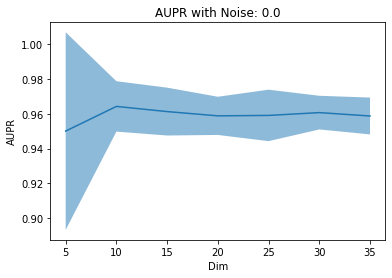

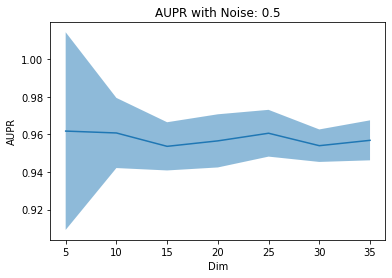

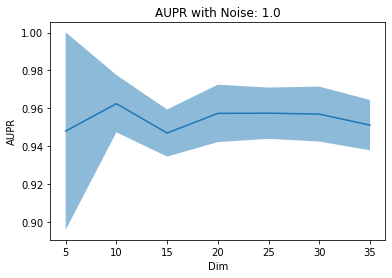

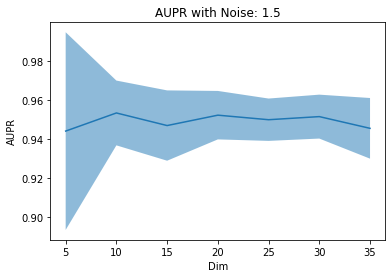

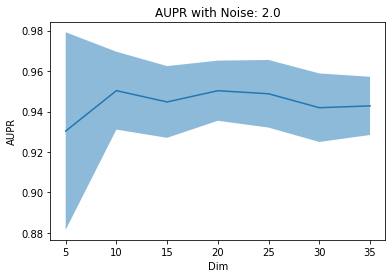

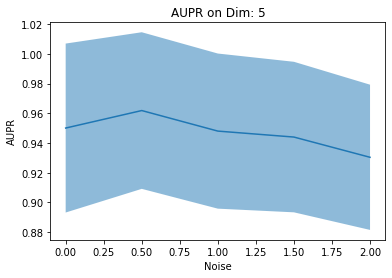

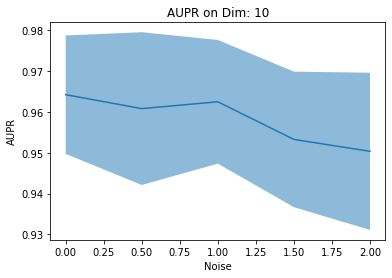

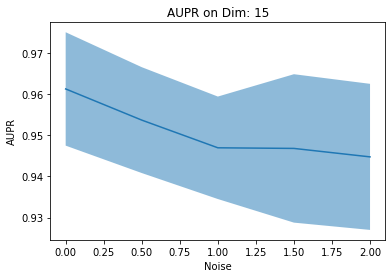

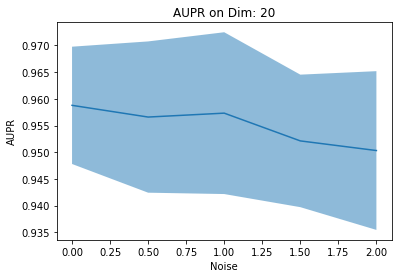

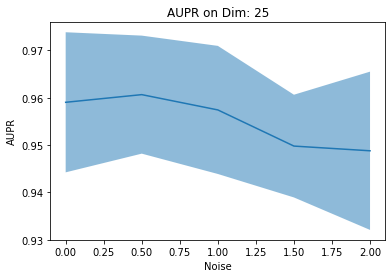

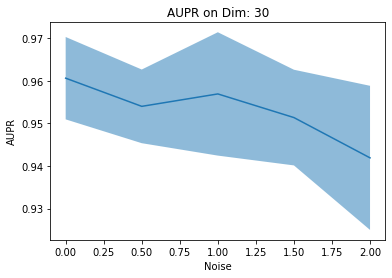

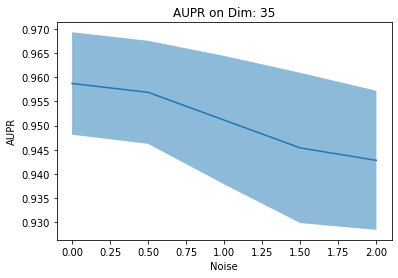

\hline
Dim$\backslash$Noise Std & 0.0 & 0.5 & 1.0 & 1.5 & 2.0\\
\hline
5 & 0.95$\pm$0.06 & 0.96$\pm$0.05 & 0.95$\pm$0.05 & 0.94$\pm$0.05 & 0.93$\pm$0.05\\
10 & 0.96$\pm$0.01 & 0.96$\pm$0.02 & 0.96$\pm$0.02 & 0.95$\pm$0.02 & 0.95$\pm$0.02\\
15 & 0.96$\pm$0.01 & 0.95$\pm$0.01 & 0.95$\pm$0.01 & 0.95$\pm$0.02 & 0.94$\pm$0.02\\
20 & 0.96$\pm$0.01 & 0.96$\pm$0.01 & 0.96$\pm$0.02 & 0.95$\pm$0.01 & 0.95$\pm$0.01\\
25 & 0.96$\pm$0.01 & 0.96$\pm$0.01 & 0.96$\pm$0.01 & 0.95$\pm$0.01 & 0.95$\pm$0.02\\
30 & 0.96$\pm$0.01 & 0.95$\pm$0.01 & 0.96$\pm$0.01 & 0.95$\pm$0.01 & 0.94$\pm$0.02\\
35 & 0.96$\pm$0.01 & 0.96$\pm$0.01 & 0.95$\pm$0.01 & 0.95$\pm$0.02 & 0.94$\pm$0.01\\
\hline


In [8]:
auprs_mean, auprs_std = get_results(dims, noises, data="linear", loss='bce',
                repeats=20, plot=True, latex=True)

# Linear Classification with $\sigma=0.5$

## MSE

### 100 Data Samples

5D noisy data, 0.0 stdev
5D noisy data, 0.5 stdev
5D noisy data, 1.0 stdev
5D noisy data, 1.5 stdev
5D noisy data, 2.0 stdev
Dimension: 5


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.976377,0.071143
1,0.5,0.969440,0.069494
2,1.0,0.964250,0.070474
3,1.5,0.965026,0.067005
4,2.0,0.957621,0.071203


10D noisy data, 0.0 stdev
10D noisy data, 0.5 stdev
10D noisy data, 1.0 stdev
10D noisy data, 1.5 stdev
10D noisy data, 2.0 stdev
Dimension: 10


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.938636,0.086313
1,0.5,0.952753,0.072444
2,1.0,0.907204,0.082842
3,1.5,0.904546,0.081320
4,2.0,0.920162,0.072732


15D noisy data, 0.0 stdev
15D noisy data, 0.5 stdev
15D noisy data, 1.0 stdev
15D noisy data, 1.5 stdev
15D noisy data, 2.0 stdev
Dimension: 15


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.920692,0.072610
1,0.5,0.898537,0.076371
2,1.0,0.919128,0.071409
3,1.5,0.903488,0.073321
4,2.0,0.893146,0.068126


20D noisy data, 0.0 stdev
20D noisy data, 0.5 stdev
20D noisy data, 1.0 stdev
20D noisy data, 1.5 stdev
20D noisy data, 2.0 stdev
Dimension: 20


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.876255,0.046814
1,0.5,0.886640,0.066723
2,1.0,0.889083,0.070676
3,1.5,0.877373,0.057625
4,2.0,0.871362,0.061798


25D noisy data, 0.0 stdev
25D noisy data, 0.5 stdev
25D noisy data, 1.0 stdev
25D noisy data, 1.5 stdev
25D noisy data, 2.0 stdev
Dimension: 25


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.875970,0.042100
1,0.5,0.879198,0.050566
2,1.0,0.877873,0.046981
3,1.5,0.872926,0.056393
4,2.0,0.871048,0.043060


30D noisy data, 0.0 stdev
30D noisy data, 0.5 stdev
30D noisy data, 1.0 stdev
30D noisy data, 1.5 stdev
30D noisy data, 2.0 stdev
Dimension: 30


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.869760,0.055399
1,0.5,0.864408,0.050564
2,1.0,0.863150,0.052585
3,1.5,0.876412,0.055274
4,2.0,0.857085,0.052907


35D noisy data, 0.0 stdev
35D noisy data, 0.5 stdev
35D noisy data, 1.0 stdev
35D noisy data, 1.5 stdev
35D noisy data, 2.0 stdev
Dimension: 35


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.871540,0.052281
1,0.5,0.864078,0.053550
2,1.0,0.866984,0.053141
3,1.5,0.868911,0.056264
4,2.0,0.861969,0.056901


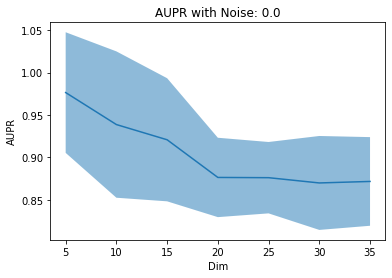

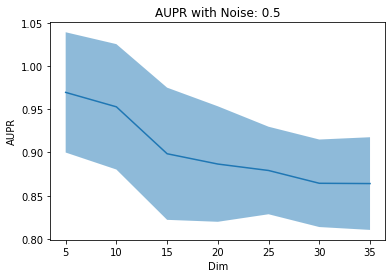

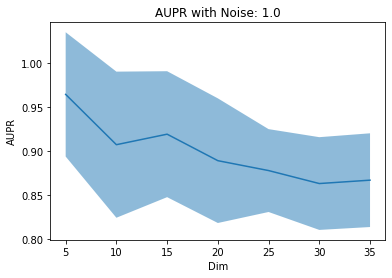

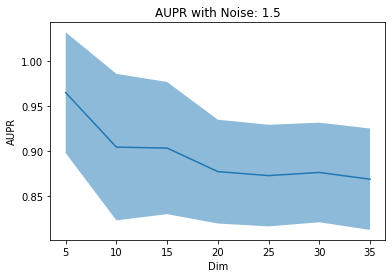

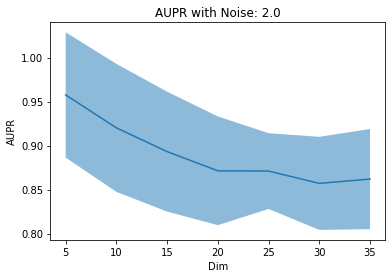

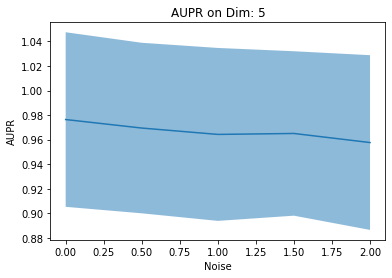

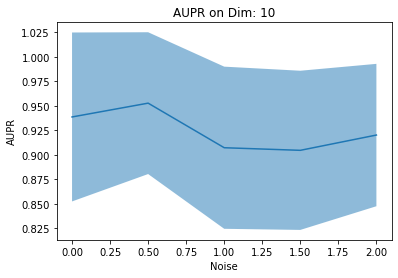

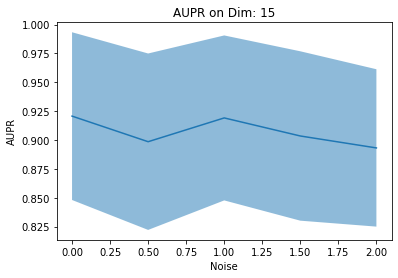

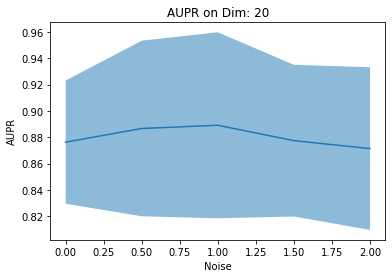

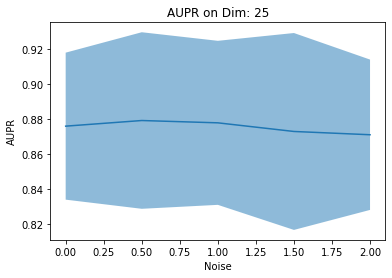

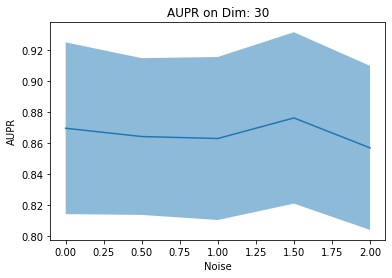

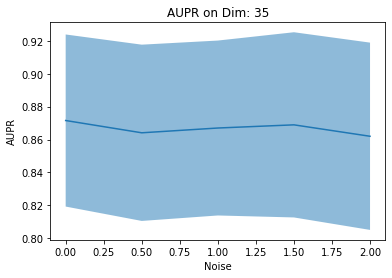

\hline
Noise Std$\backslash$Dim & 5 & 10 & 15 & 20 & 25 & 30 & 35\\
\hline
0.0 & 0.98$\pm$0.07 & 0.97$\pm$0.07 & 0.96$\pm$0.07 & 0.97$\pm$0.07 & 0.96$\pm$0.07\\
0.5 & 0.94$\pm$0.09 & 0.95$\pm$0.07 & 0.91$\pm$0.08 & 0.9$\pm$0.08 & 0.92$\pm$0.07\\
1.0 & 0.92$\pm$0.07 & 0.9$\pm$0.08 & 0.92$\pm$0.07 & 0.9$\pm$0.07 & 0.89$\pm$0.07\\
1.5 & 0.88$\pm$0.05 & 0.89$\pm$0.07 & 0.89$\pm$0.07 & 0.88$\pm$0.06 & 0.87$\pm$0.06\\
2.0 & 0.88$\pm$0.04 & 0.88$\pm$0.05 & 0.88$\pm$0.05 & 0.87$\pm$0.06 & 0.87$\pm$0.04\\
\hline


In [9]:
sigma = 0.5
auprs_mean, auprs_std = get_results(dims, noises, data="constant", loss='mse', sigma=sigma,
                repeats=20, plot=True, latex=True, transpose=False)

### Amount of Data = $20 \times$ Dimension

5D noisy data, 0.0 stdev
5D noisy data, 0.5 stdev
5D noisy data, 1.0 stdev
5D noisy data, 1.5 stdev
5D noisy data, 2.0 stdev
Dimension: 5


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.976377,0.071143
1,0.5,0.969440,0.069494
2,1.0,0.964250,0.070474
3,1.5,0.965026,0.067005
4,2.0,0.957621,0.071203


10D noisy data, 0.0 stdev
10D noisy data, 0.5 stdev
10D noisy data, 1.0 stdev
10D noisy data, 1.5 stdev
10D noisy data, 2.0 stdev
Dimension: 10


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.981006,0.060366
1,0.5,0.977235,0.062264
2,1.0,0.984285,0.042881
3,1.5,0.970891,0.063269
4,2.0,0.959510,0.067277


15D noisy data, 0.0 stdev
15D noisy data, 0.5 stdev
15D noisy data, 1.0 stdev
15D noisy data, 1.5 stdev
15D noisy data, 2.0 stdev
Dimension: 15


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.981547,0.059333
1,0.5,0.982662,0.054594
2,1.0,0.978392,0.055518
3,1.5,0.978339,0.053857
4,2.0,0.956247,0.066165


20D noisy data, 0.0 stdev
20D noisy data, 0.5 stdev
20D noisy data, 1.0 stdev
20D noisy data, 1.5 stdev
20D noisy data, 2.0 stdev
Dimension: 20


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.955072,0.079157
1,0.5,0.941736,0.082161
2,1.0,0.950194,0.083753
3,1.5,0.962611,0.059711
4,2.0,0.946821,0.073190


25D noisy data, 0.0 stdev
25D noisy data, 0.5 stdev
25D noisy data, 1.0 stdev
25D noisy data, 1.5 stdev
25D noisy data, 2.0 stdev
Dimension: 25


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.971219,0.070418
1,0.5,0.977193,0.059242
2,1.0,0.973860,0.055216
3,1.5,0.958669,0.069498
4,2.0,0.973831,0.041489


30D noisy data, 0.0 stdev
30D noisy data, 0.5 stdev
30D noisy data, 1.0 stdev
30D noisy data, 1.5 stdev
30D noisy data, 2.0 stdev
Dimension: 30


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.956703,0.087757
1,0.5,0.955250,0.083994
2,1.0,0.931829,0.094485
3,1.5,0.937641,0.085310
4,2.0,0.957837,0.064714


35D noisy data, 0.0 stdev
35D noisy data, 0.5 stdev
35D noisy data, 1.0 stdev
35D noisy data, 1.5 stdev
35D noisy data, 2.0 stdev
Dimension: 35


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.949789,0.088076
1,0.5,0.955141,0.083343
2,1.0,0.941945,0.085889
3,1.5,0.933960,0.090185
4,2.0,0.949666,0.070364


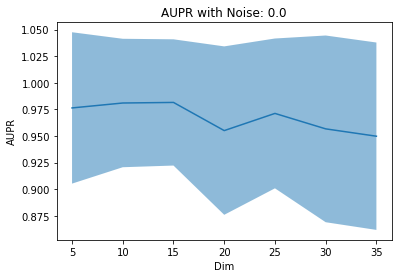

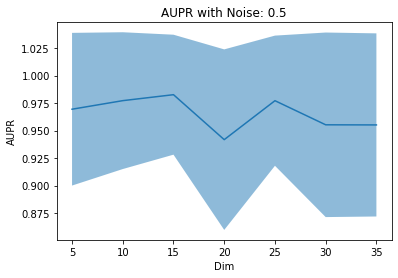

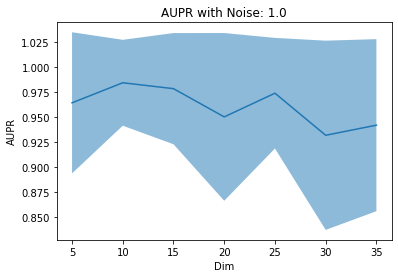

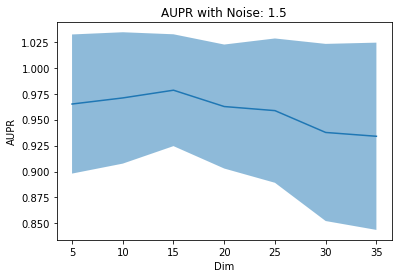

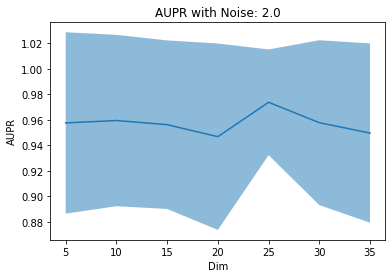

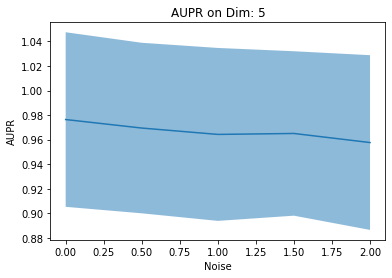

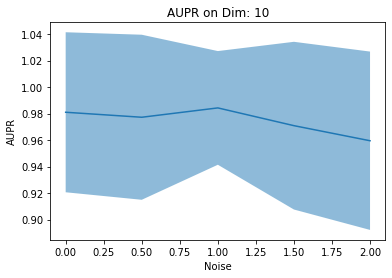

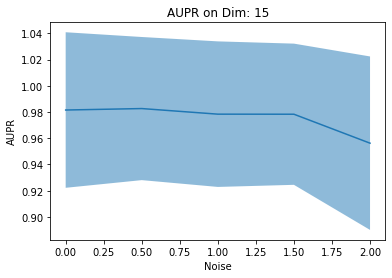

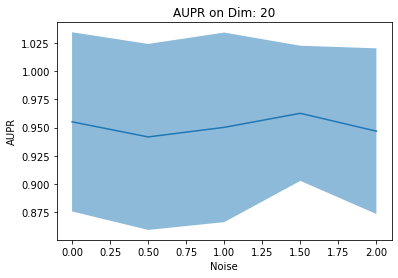

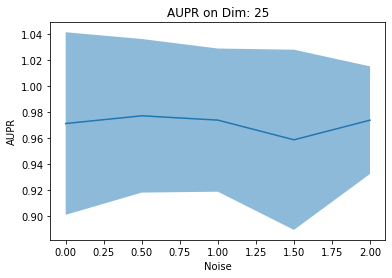

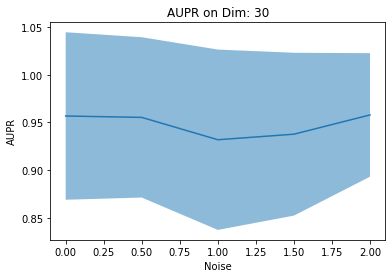

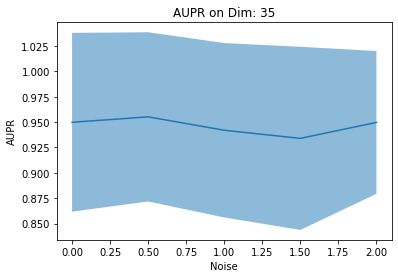

\hline
Noise Std$\backslash$Dim & 5 & 10 & 15 & 20 & 25 & 30 & 35\\
\hline
0.0 & 0.98$\pm$0.07 & 0.97$\pm$0.07 & 0.96$\pm$0.07 & 0.97$\pm$0.07 & 0.96$\pm$0.07\\
0.5 & 0.98$\pm$0.06 & 0.98$\pm$0.06 & 0.98$\pm$0.04 & 0.97$\pm$0.06 & 0.96$\pm$0.07\\
1.0 & 0.98$\pm$0.06 & 0.98$\pm$0.05 & 0.98$\pm$0.06 & 0.98$\pm$0.05 & 0.96$\pm$0.07\\
1.5 & 0.96$\pm$0.08 & 0.94$\pm$0.08 & 0.95$\pm$0.08 & 0.96$\pm$0.06 & 0.95$\pm$0.07\\
2.0 & 0.97$\pm$0.07 & 0.98$\pm$0.06 & 0.97$\pm$0.06 & 0.96$\pm$0.07 & 0.97$\pm$0.04\\
\hline


In [10]:
auprs_mean, auprs_std = get_results(dims, noises, data="linear", loss='mse', sigma=sigma,
                repeats=20, plot=True, latex=True, transpose=False)

## Log Loss

### 100 Data Samples

5D noisy data, 0.0 stdev
5D noisy data, 0.5 stdev
5D noisy data, 1.0 stdev
5D noisy data, 1.5 stdev
5D noisy data, 2.0 stdev
Dimension: 5


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.981818,0.056301
1,0.5,0.980066,0.056149
2,1.0,0.961447,0.054898
3,1.5,0.962921,0.055651
4,2.0,0.961088,0.054052


10D noisy data, 0.0 stdev
10D noisy data, 0.5 stdev
10D noisy data, 1.0 stdev
10D noisy data, 1.5 stdev
10D noisy data, 2.0 stdev
Dimension: 10


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.985815,0.052288
1,0.5,0.980324,0.051576
2,1.0,0.961773,0.065413
3,1.5,0.972225,0.051359
4,2.0,0.959151,0.053413


15D noisy data, 0.0 stdev
15D noisy data, 0.5 stdev
15D noisy data, 1.0 stdev
15D noisy data, 1.5 stdev
15D noisy data, 2.0 stdev
Dimension: 15


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.946542,0.078551
1,0.5,0.936083,0.073406
2,1.0,0.960063,0.065792
3,1.5,0.958403,0.067154
4,2.0,0.941184,0.060475


20D noisy data, 0.0 stdev
20D noisy data, 0.5 stdev
20D noisy data, 1.0 stdev
20D noisy data, 1.5 stdev
20D noisy data, 2.0 stdev
Dimension: 20


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.922189,0.081658
1,0.5,0.896162,0.078840
2,1.0,0.903451,0.080614
3,1.5,0.918974,0.073070
4,2.0,0.903362,0.077584


25D noisy data, 0.0 stdev
25D noisy data, 0.5 stdev
25D noisy data, 1.0 stdev
25D noisy data, 1.5 stdev
25D noisy data, 2.0 stdev
Dimension: 25


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.917430,0.070082
1,0.5,0.888152,0.054134
2,1.0,0.897494,0.059867
3,1.5,0.889469,0.056223
4,2.0,0.879983,0.063775


30D noisy data, 0.0 stdev
30D noisy data, 0.5 stdev
30D noisy data, 1.0 stdev
30D noisy data, 1.5 stdev
30D noisy data, 2.0 stdev
Dimension: 30


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.875263,0.060962
1,0.5,0.873826,0.062890
2,1.0,0.875266,0.062789
3,1.5,0.877734,0.057827
4,2.0,0.865348,0.051140


35D noisy data, 0.0 stdev
35D noisy data, 0.5 stdev
35D noisy data, 1.0 stdev
35D noisy data, 1.5 stdev
35D noisy data, 2.0 stdev
Dimension: 35


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.882076,0.053096
1,0.5,0.872556,0.057737
2,1.0,0.884368,0.057174
3,1.5,0.866138,0.056431
4,2.0,0.870699,0.054356


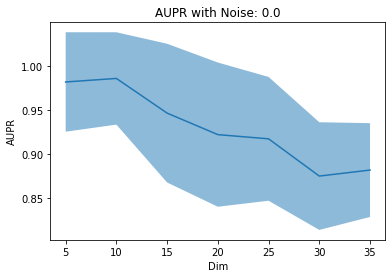

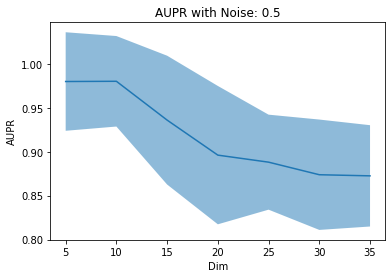

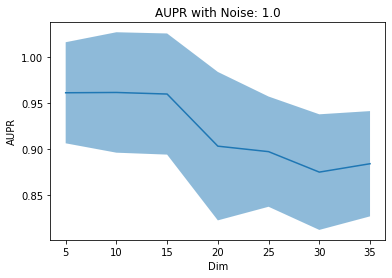

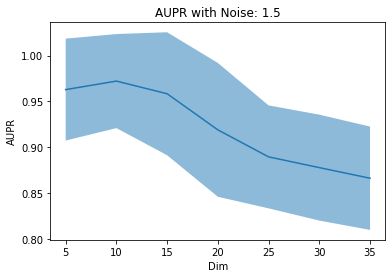

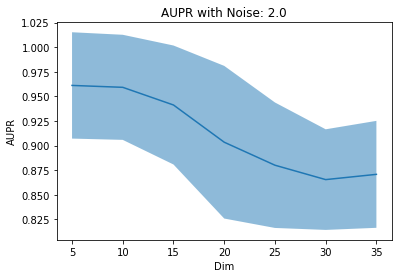

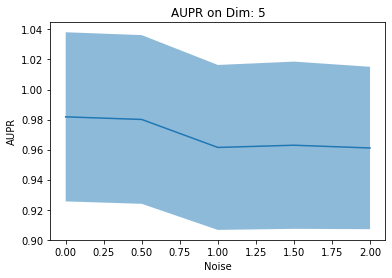

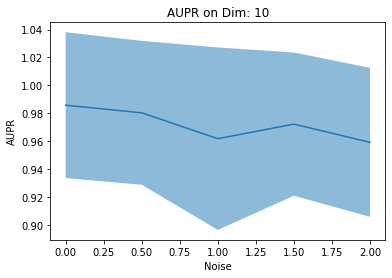

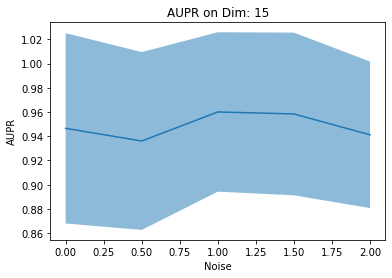

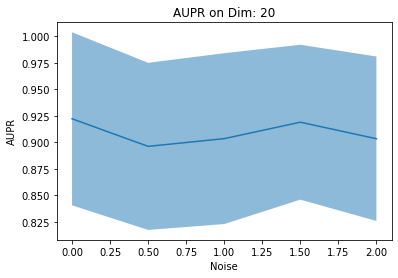

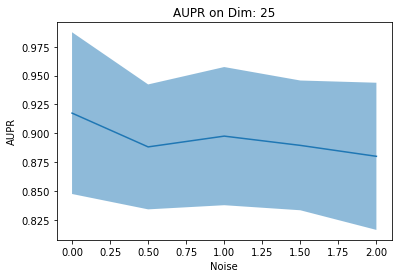

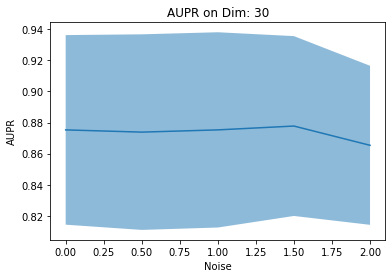

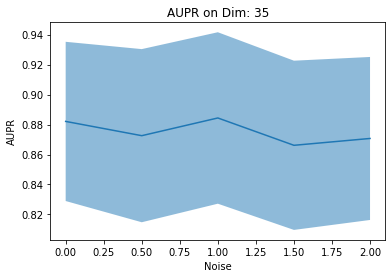

\hline
Noise Std$\backslash$Dim & 5 & 10 & 15 & 20 & 25 & 30 & 35\\
\hline
0.0 & 0.98$\pm$0.06 & 0.98$\pm$0.06 & 0.96$\pm$0.05 & 0.96$\pm$0.06 & 0.96$\pm$0.05\\
0.5 & 0.99$\pm$0.05 & 0.98$\pm$0.05 & 0.96$\pm$0.07 & 0.97$\pm$0.05 & 0.96$\pm$0.05\\
1.0 & 0.95$\pm$0.08 & 0.94$\pm$0.07 & 0.96$\pm$0.07 & 0.96$\pm$0.07 & 0.94$\pm$0.06\\
1.5 & 0.92$\pm$0.08 & 0.9$\pm$0.08 & 0.9$\pm$0.08 & 0.92$\pm$0.07 & 0.9$\pm$0.08\\
2.0 & 0.92$\pm$0.07 & 0.89$\pm$0.05 & 0.9$\pm$0.06 & 0.89$\pm$0.06 & 0.88$\pm$0.06\\
\hline


In [11]:
auprs_mean, auprs_std = get_results(dims, noises, data="constant", loss='bce', sigma=sigma,
                repeats=20, plot=True, latex=True, transpose=False)

### Amount of Data = $20 \times$ Dimension

5D noisy data, 0.0 stdev
5D noisy data, 0.5 stdev
5D noisy data, 1.0 stdev
5D noisy data, 1.5 stdev
5D noisy data, 2.0 stdev
Dimension: 5


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.981818,0.056301
1,0.5,0.980066,0.056149
2,1.0,0.961447,0.054898
3,1.5,0.962921,0.055651
4,2.0,0.961088,0.054052


10D noisy data, 0.0 stdev
10D noisy data, 0.5 stdev
10D noisy data, 1.0 stdev
10D noisy data, 1.5 stdev
10D noisy data, 2.0 stdev
Dimension: 10


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.973415,0.055278
1,0.5,0.973274,0.053072
2,1.0,0.967401,0.054820
3,1.5,0.960977,0.048584
4,2.0,0.950214,0.051165


15D noisy data, 0.0 stdev
15D noisy data, 0.5 stdev
15D noisy data, 1.0 stdev
15D noisy data, 1.5 stdev
15D noisy data, 2.0 stdev
Dimension: 15


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.970627,0.055086
1,0.5,0.961551,0.051676
2,1.0,0.958643,0.053358
3,1.5,0.945602,0.049235
4,2.0,0.940041,0.049815


20D noisy data, 0.0 stdev
20D noisy data, 0.5 stdev
20D noisy data, 1.0 stdev
20D noisy data, 1.5 stdev
20D noisy data, 2.0 stdev
Dimension: 20


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.957795,0.069839
1,0.5,0.950894,0.069130
2,1.0,0.932792,0.075374
3,1.5,0.942847,0.040963
4,2.0,0.942333,0.037053


25D noisy data, 0.0 stdev
25D noisy data, 0.5 stdev
25D noisy data, 1.0 stdev
25D noisy data, 1.5 stdev
25D noisy data, 2.0 stdev
Dimension: 25


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.957694,0.058771
1,0.5,0.965982,0.048371
2,1.0,0.947619,0.060471
3,1.5,0.952306,0.041668
4,2.0,0.929630,0.053664


30D noisy data, 0.0 stdev
30D noisy data, 0.5 stdev
30D noisy data, 1.0 stdev
30D noisy data, 1.5 stdev
30D noisy data, 2.0 stdev
Dimension: 30


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.952222,0.062182
1,0.5,0.950047,0.068511
2,1.0,0.942829,0.067027
3,1.5,0.938571,0.063483
4,2.0,0.929928,0.061818


35D noisy data, 0.0 stdev
35D noisy data, 0.5 stdev
35D noisy data, 1.0 stdev
35D noisy data, 1.5 stdev
35D noisy data, 2.0 stdev
Dimension: 35


,Noise,AUPR Mean,AUPR StDev
0,0.0,0.951306,0.069409
1,0.5,0.950526,0.060288
2,1.0,0.914843,0.073718
3,1.5,0.914823,0.073105
4,2.0,0.918576,0.068072


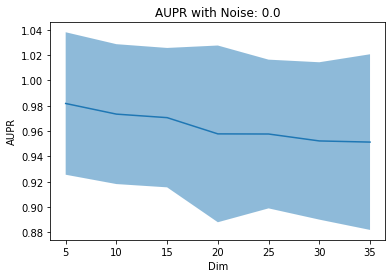

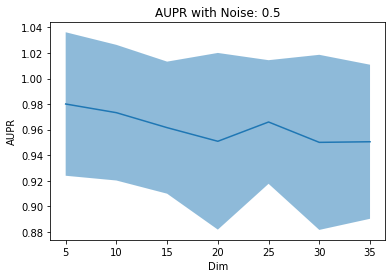

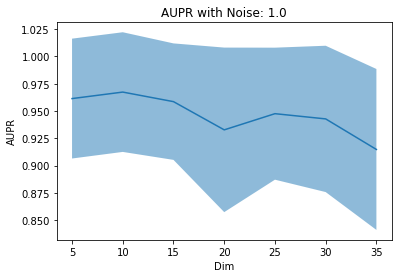

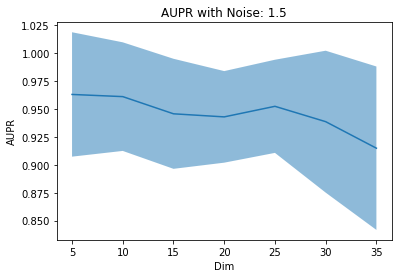

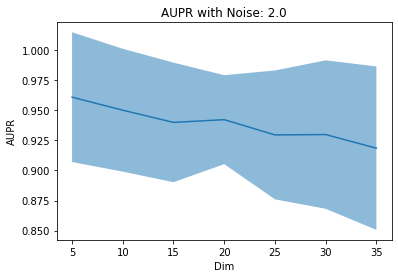

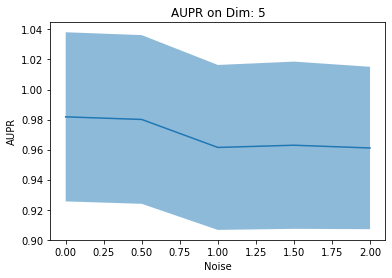

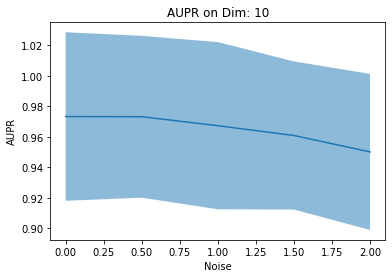

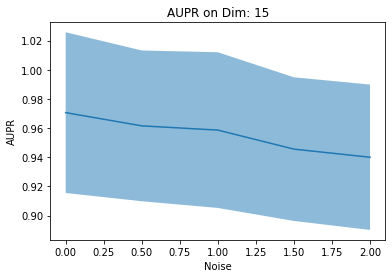

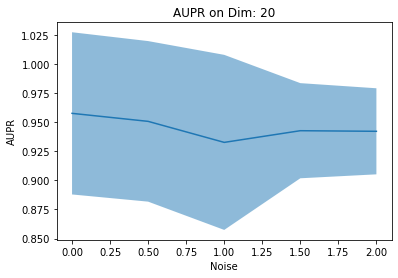

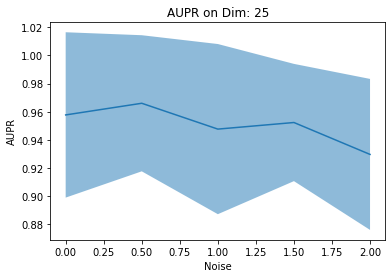

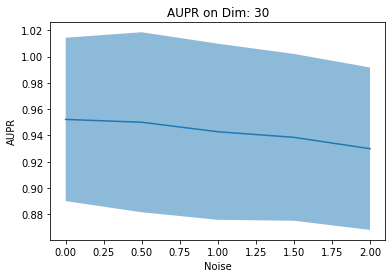

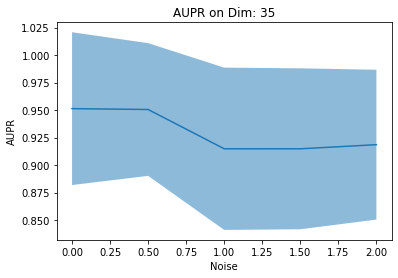

\hline
Noise Std$\backslash$Dim & 5 & 10 & 15 & 20 & 25 & 30 & 35\\
\hline
0.0 & 0.98$\pm$0.06 & 0.98$\pm$0.06 & 0.96$\pm$0.05 & 0.96$\pm$0.06 & 0.96$\pm$0.05\\
0.5 & 0.97$\pm$0.06 & 0.97$\pm$0.05 & 0.97$\pm$0.05 & 0.96$\pm$0.05 & 0.95$\pm$0.05\\
1.0 & 0.97$\pm$0.06 & 0.96$\pm$0.05 & 0.96$\pm$0.05 & 0.95$\pm$0.05 & 0.94$\pm$0.05\\
1.5 & 0.96$\pm$0.07 & 0.95$\pm$0.07 & 0.93$\pm$0.08 & 0.94$\pm$0.04 & 0.94$\pm$0.04\\
2.0 & 0.96$\pm$0.06 & 0.97$\pm$0.05 & 0.95$\pm$0.06 & 0.95$\pm$0.04 & 0.93$\pm$0.05\\
\hline


In [12]:
auprs_mean, auprs_std = get_results(dims, noises, data="linear", loss='bce', sigma=sigma,
                repeats=20, plot=True, latex=True, transpose=False)